# 2. Detrending long term stellar variability is important for finding planets

When hunting for exoplanet candidates, it is important to accurately remove the stellar variability. This is particularly important for the Kepler/K2 dataset, as many stars are young stars and smaller, more active stars. This can cause much larger, and short term variaibilty which can confound exoplanet searches. 

In this notebook I will show you a **second unidentified K2 Planet Candidate** that has been overlooked due to the extreme stellar variability. K2-198b was first reported in [Mayo et al 2018](https://arxiv.org/pdf/1802.05277.pdf). However, if the stellar variability is carefully removed, a second planet candidate will emerge. This detrending is difficult to do on a large scale to multiple targets, and as it is outlined below is more of a bespoke analysis, which is why this planet candidate has remained ellusive.

The work below is a quick and easy demo of the power of GPs to detrend long term trends. The new `exoplanet` package is designed to fit planet transits and long term variability simultaneously, very quickly, and much more accurately. You can find it [here](https://exoplanet.dfm.io/en/stable/)). I highly recommend it for this work. In the future, I'll be improving this fit using the `exoplanet` package.


*Note: The GP corrector used below is a feature of `lightkurve` that is currently under development. Checkout my GPCorrector development branch if you'd like to run this notebook for yourself!*

# Finding K2-198c

First, we can obtain the K2 data using `lightkurve`. In this case, I've written a short script to scrape the HLSPs available for this target, available in the `scripts.py` file. Below I download the data and plot up the three HLSPs available for this target.

In [2]:
import lightkurve as lk
from scripts import fetch_hlsps
import numpy as np
import matplotlib.pyplot as plt
plt.style.use(lk.MPLSTYLE)

In [3]:
lcfs = lk.search_lightcurvefile('EPIC 212768333').download_all()

Text(0.5,1,'EPIC 212768333 Campaign 6')

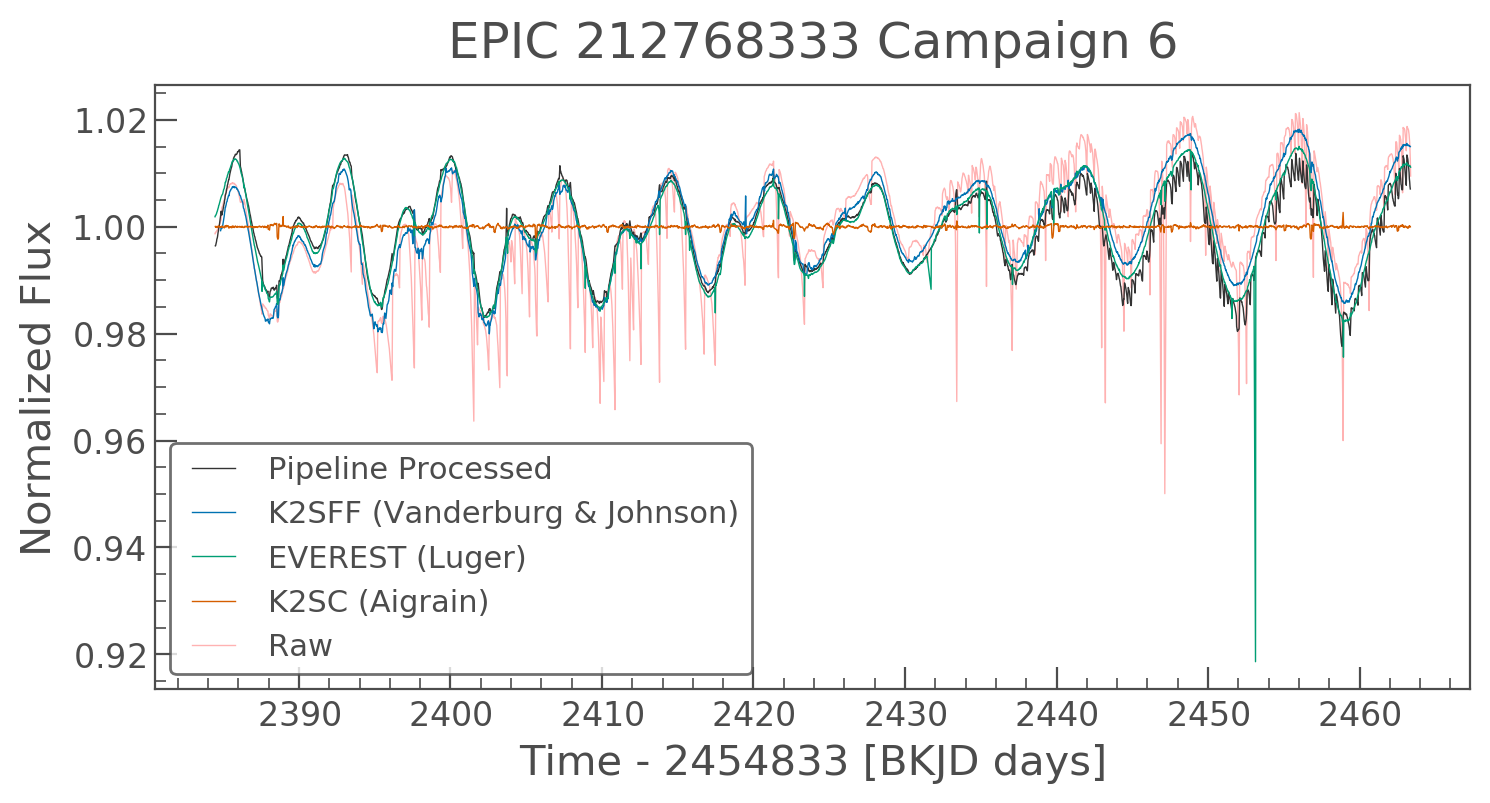

In [4]:
ax = lcfs[0].PDCSAP_FLUX.remove_outliers(10).plot(label='Pipeline Processed')
hlsps = fetch_hlsps(lcfs[0].PDCSAP_FLUX)
for hlsp in hlsps:
    hlsp.remove_outliers(10).plot(ax=ax)

lcfs[0].SAP_FLUX.remove_outliers(10).plot(ax=ax, label='Raw', c='r', alpha=0.3, zorder=-10)
ax.set_title('EPIC {} Campaign {}'.format(lcfs[0].targetid, lcfs[0].campaign))

In the previous notebook I demonstrated how it is possible to find a planet signal using `lightkurve`. For this notebook, to keep things simple and quick, I've found the period, duration and transit midpoint of the planet candidate for you already.

In [5]:
period_1, duration_1, t0_1 = 17.043179, 0.1, 2.56556209
period_2, duration_2, t0_2 = 7.4501501, 0.1, 3.9710900554918567

Below I'll demonstrate a GP fit to the long term trends in the Kepler Pipeline light curve.

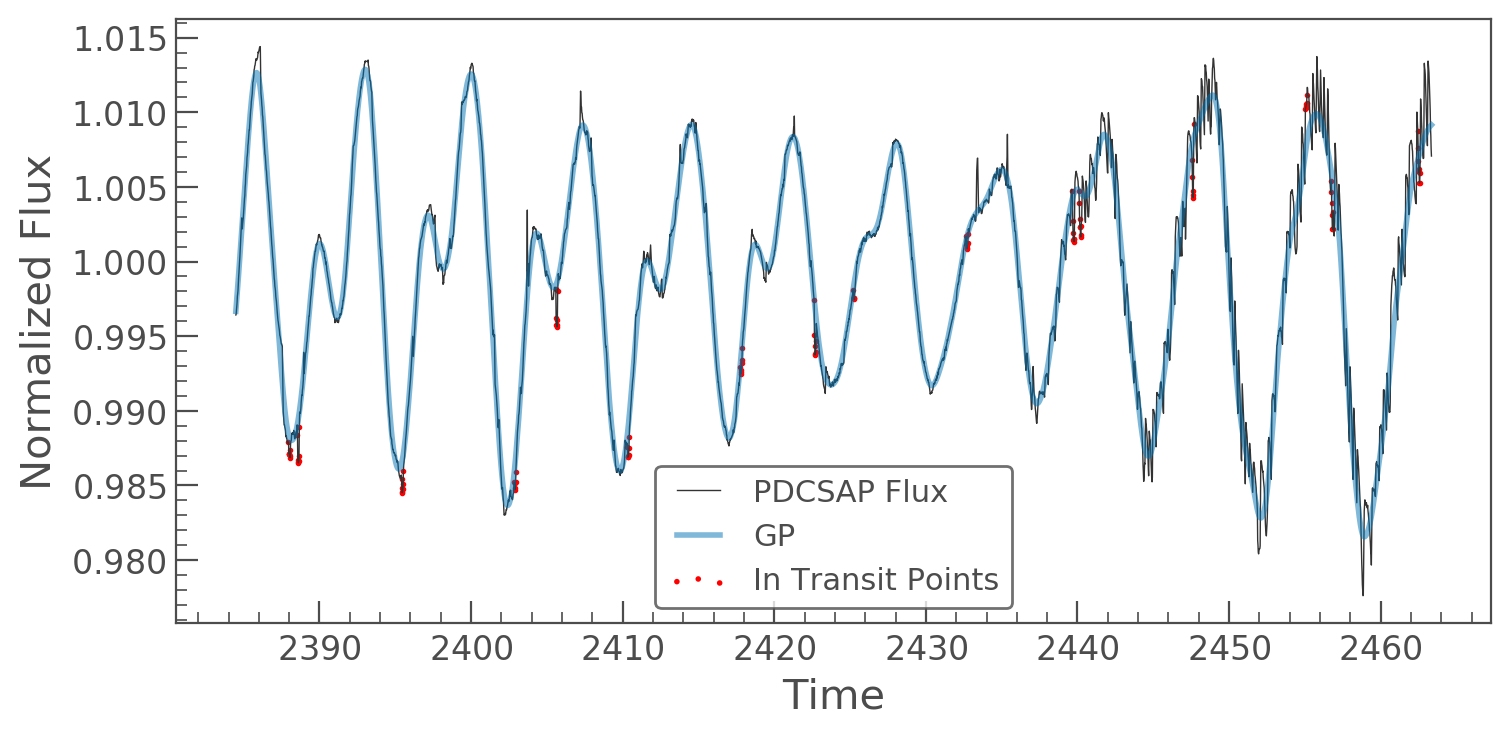

In [6]:
# Use the PDCSAP Flux
lc = lcfs[0].PDCSAP_FLUX.remove_nans().normalize()

# Generate a transit mask
ph = (lc.time - t0_1)/period_1 % 1
out_of_transit = (ph > ((duration_1 * 1.5)/period_1)/2) & (ph < 1 - ((duration_1 * 1.5)/period_1)/2)
ph = (lc.time - t0_2)/period_2 % 1
out_of_transit &= (ph > ((duration_2 * 1.5)/period_2)/2) & (ph < 1 - ((duration_2 * 1.5)/period_2)/2)


# Plot the data
ax = lc.plot(label='PDCSAP Flux')
lc[~out_of_transit].scatter(ax=ax, normalize=False, c='r', label='In Transit Points')

# Build a GP corrected light curve
corrected_lc, trend = lc.to_corrector('gp').correct(mask=~out_of_transit, return_trend=True, timescale=15)

# Plot the trend for comparison
trend.plot(ax=ax, lw=2, alpha=0.5, label='GP')

You can see that the GP fits the stellar variability quite well, and crucially interpolates the data during transits. Note that I am masking out the planet transits before applying the GP detrending. This is an important step, otherwise the GP will be fit to the transits themselves and they will be removed. 

However, the light curve still has noise from the K2 motion. The GP has tried to fit this variability towards the end of the light curve. To remove just the long term trends, we can use the K2 Motion detrended HLSPs.

**Note: As part of the detrending, K2SC has already had a GP fit to the stellar variability removed. As such, K2SC is a good HLSP to use if you are searching for planets around young or spotted stars.*

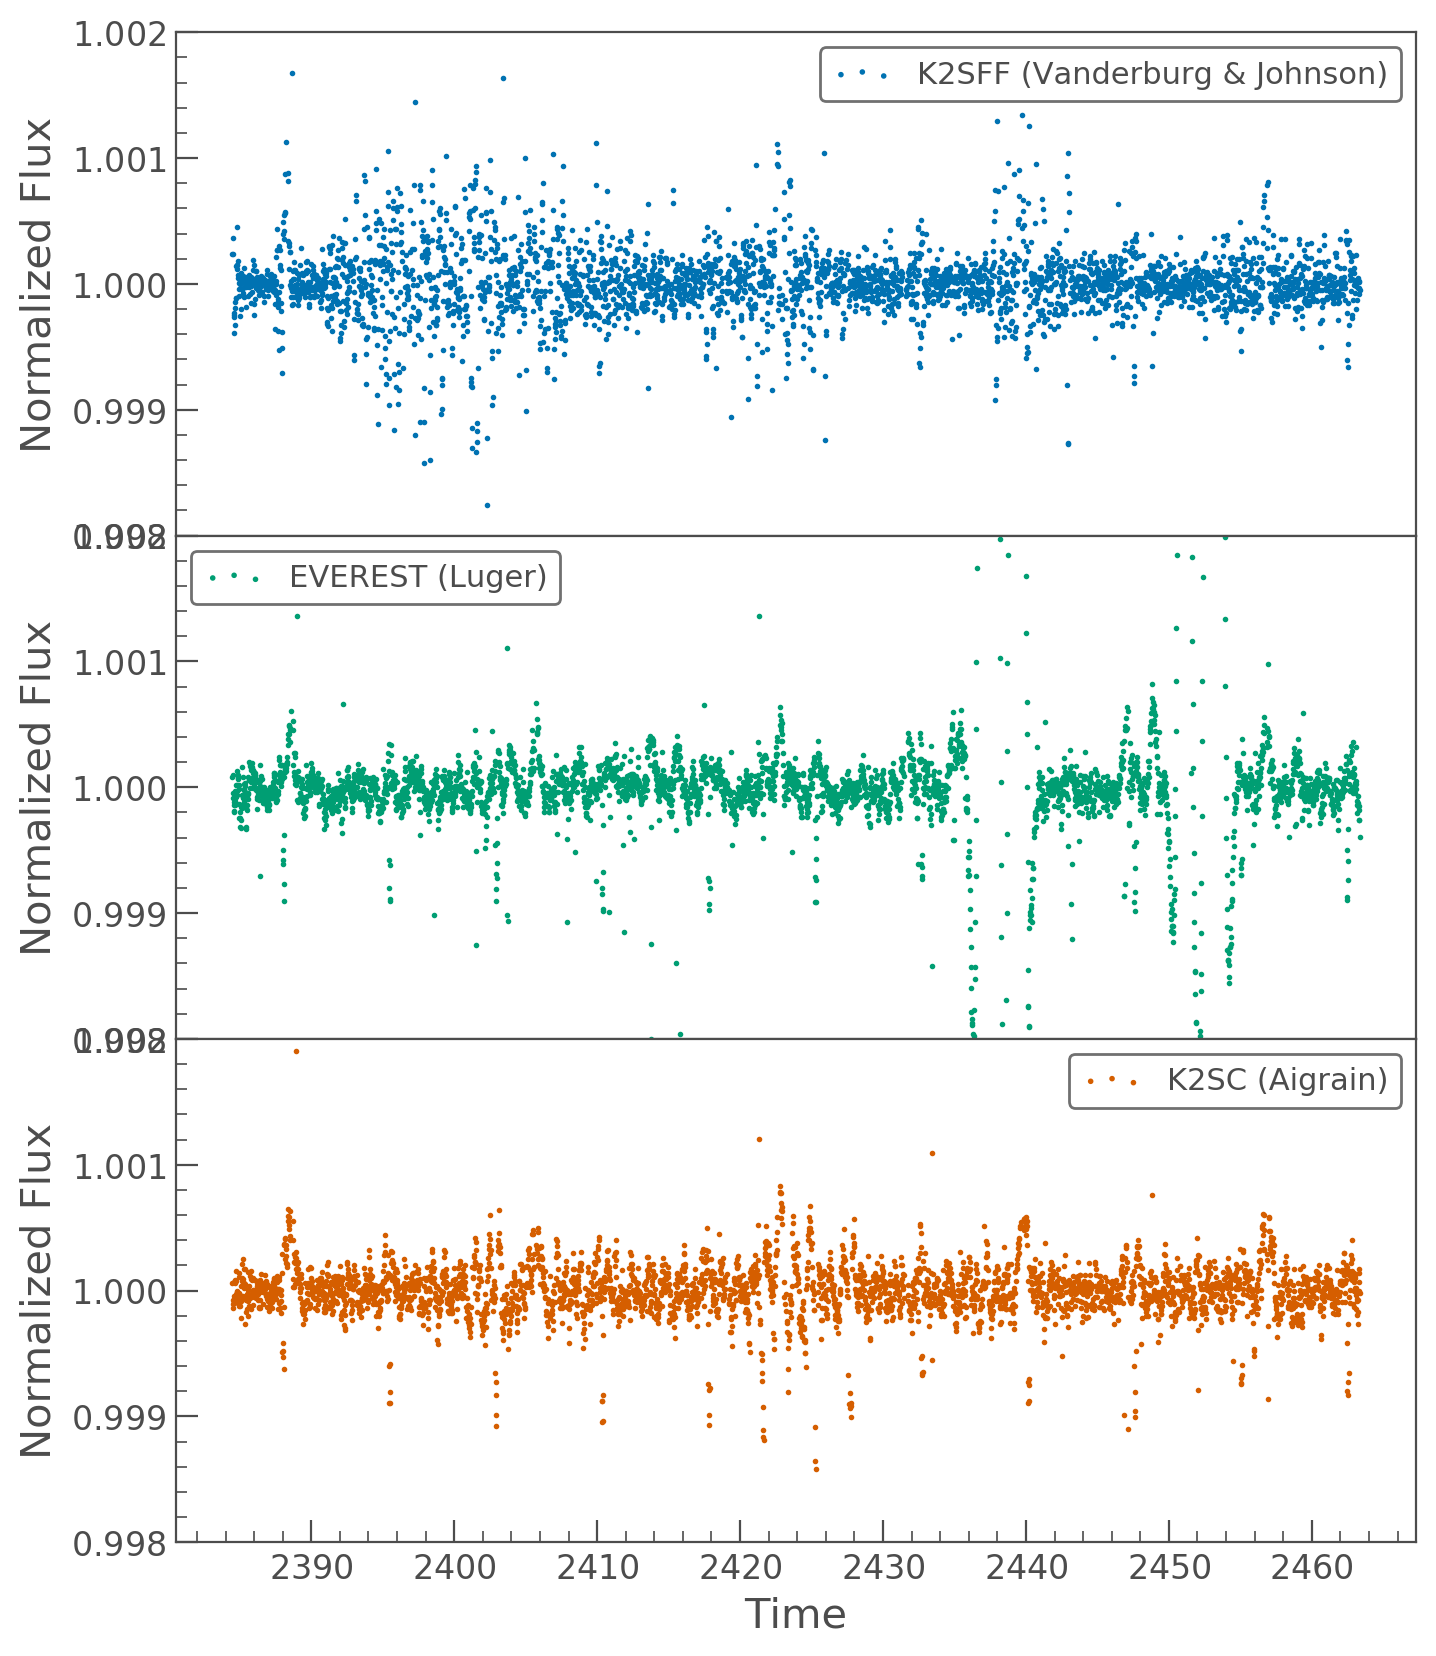

In [7]:
fig, ax = plt.subplots(3, figsize=(8, 10))
for idx, lc1 in enumerate(hlsps):
    # Mask planet 2
    lc1.flux_err[~np.isfinite(lc1.flux_err)] = 0.0005
    lc1 = lc1.remove_nans().normalize()
    lc1 = lc1[lc1.flux > 0.8]
    ph = (lc1.time - t0_1)/period_1 % 1
    out_of_transit_1 = (ph > ((duration_1 * 1.5)/period_1)/2) & (ph < 1 - ((duration_1 * 1.5)/period_1)/2)
    ph = (lc1.time - t0_2)/period_2 % 1
    out_of_transit_2 = (ph > ((duration_2 * 1.5)/period_2)/2) & (ph < 1 - ((duration_2 * 1.5)/period_2)/2)

    if idx != 2:
        lc1 = lc1.to_corrector('gp').correct(mask=(~out_of_transit_1 & ~out_of_transit_2), timescale=15, iters=3, sigma=3)
    lc1[out_of_transit_1].scatter(ax=ax[idx], c= 'C{}'.format(idx + 1))
    #ax[idx].set_xlim(-0.1, 0.1)
    ax[idx].set_ylim(0.998, 1.002)
    if idx < 2:
        ax[idx].set_xticks([])

plt.subplots_adjust(hspace=0)

We can see that the GP has done a fairly good job at removing the long term trends while preserving the transits. 

We can fold each of these detrended light curves at the period above to reveal the second transiting planet signal is apparent in all three high level science products.

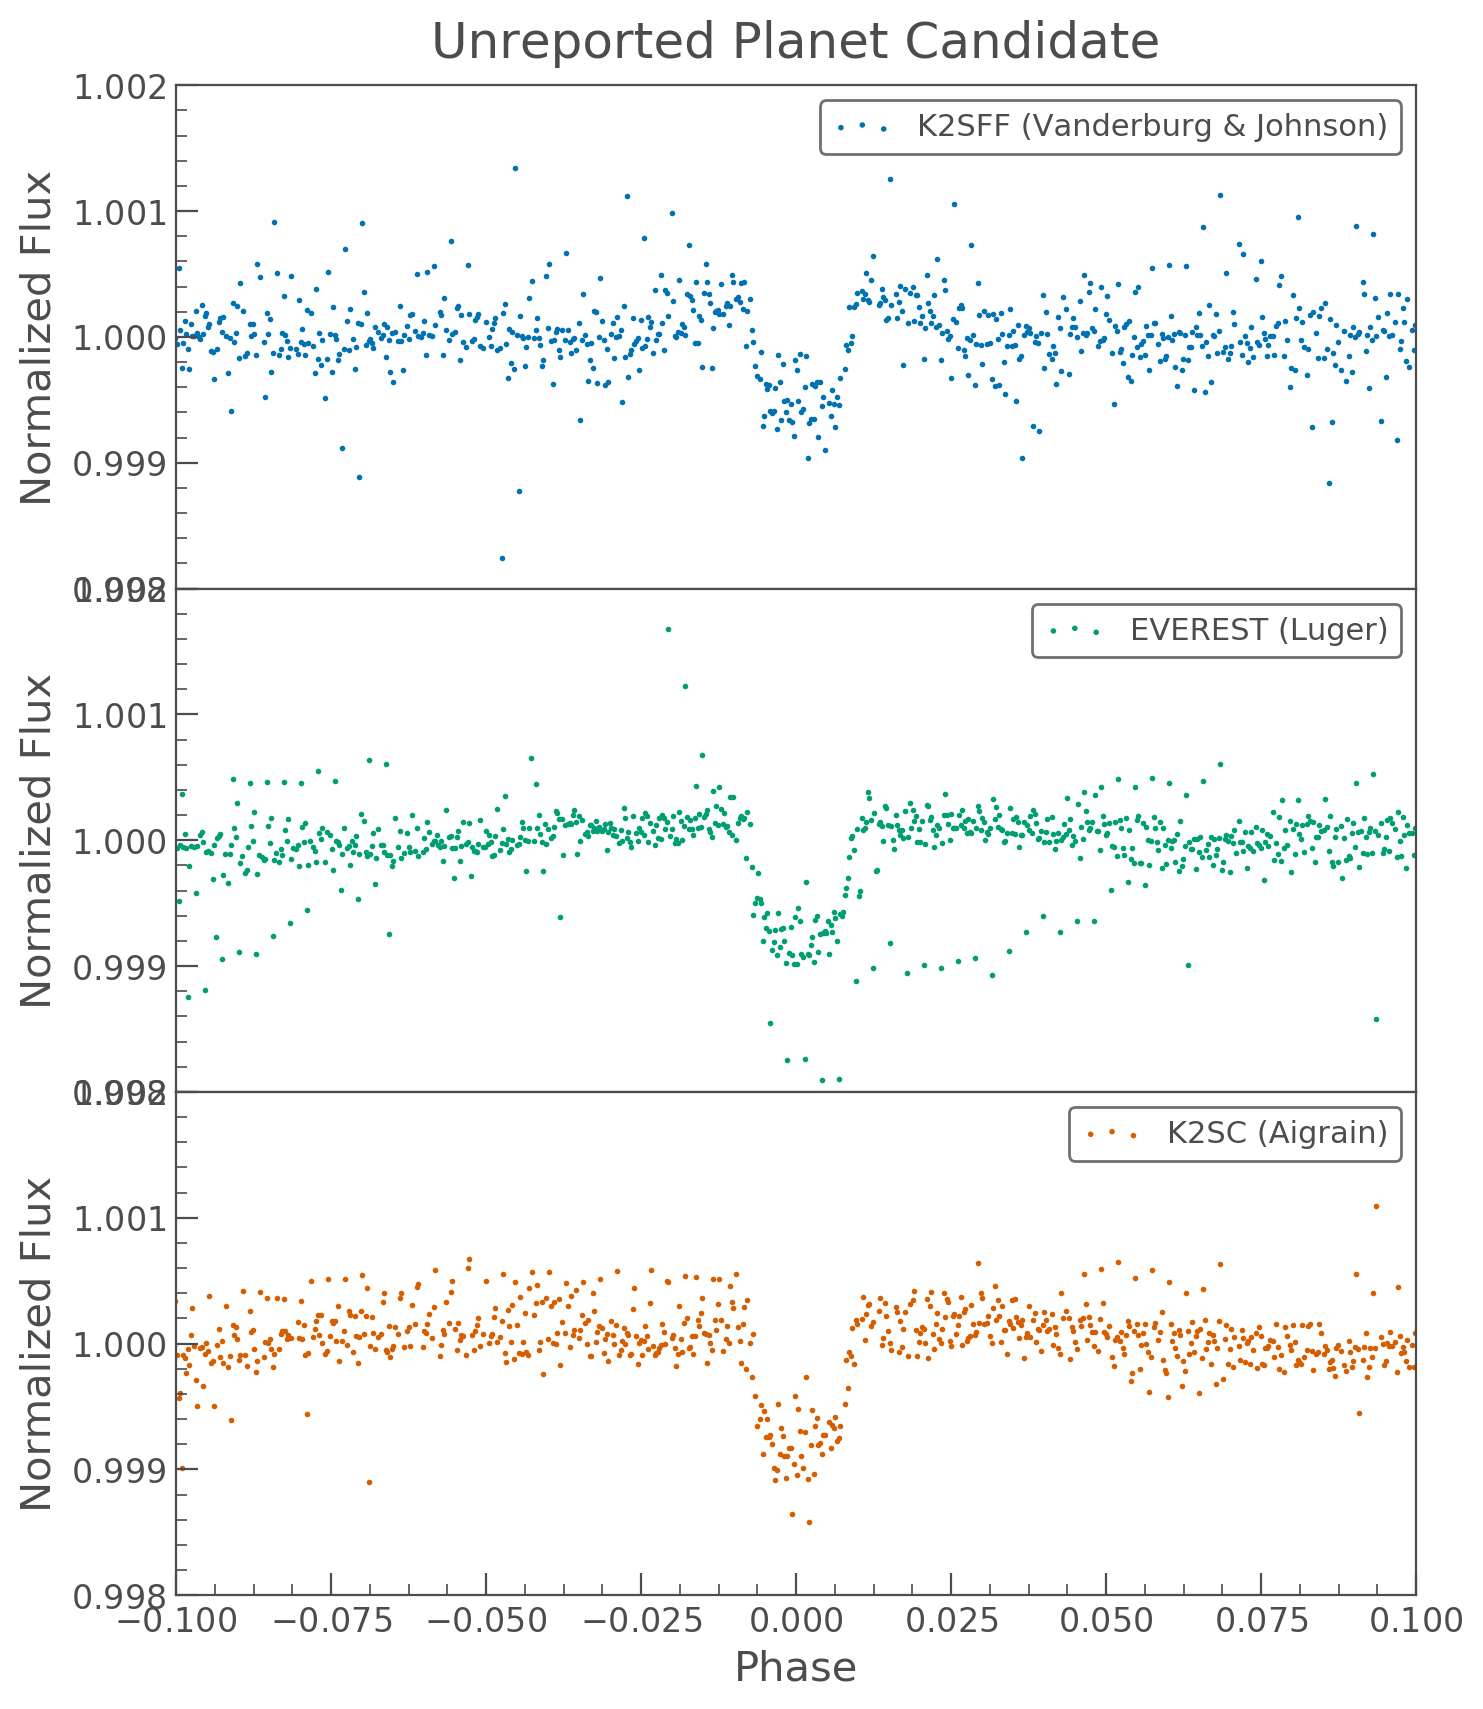

In [8]:
fig, ax = plt.subplots(3, figsize=(8, 10))
for idx, lc1 in enumerate(hlsps):
    # Mask planet 2
    lc1.flux_err[~np.isfinite(lc1.flux_err)] = 0.0005
    lc1 = lc1.remove_nans().normalize()
    lc1 = lc1[lc1.flux > 0.8]
    ph = (lc1.time - t0_1)/period_1 % 1
    out_of_transit_1 = (ph > ((duration_1 * 1.5)/period_1)/2) & (ph < 1 - ((duration_1 * 1.5)/period_1)/2)
    ph = (lc1.time - t0_2)/period_2 % 1
    out_of_transit_2 = (ph > ((duration_2 * 1.5)/period_2)/2) & (ph < 1 - ((duration_2 * 1.5)/period_2)/2)
    
    if idx != 2:
        lc1 = lc1.to_corrector('gp').correct(mask=(~out_of_transit_1 & ~out_of_transit_2), timescale=15, iters=3, sigma=3)
    lc1[out_of_transit_1].fold(period_2, t0_2).scatter(ax=ax[idx], c= 'C{}'.format(idx + 1))
    ax[idx].set_xlim(-0.1, 0.1)
    ax[idx].set_ylim(0.998, 1.002)
    if idx < 2:
        ax[idx].set_xticks([])
    if idx == 0:
        ax[idx].set_title('Unreported Planet Candidate')
plt.subplots_adjust(hspace=0)

Just for comparison, below is the transiting planet signal from K2-198b. The long term detrending can definitely be improved, for example by using a better GP kernel to fit the long term trends.

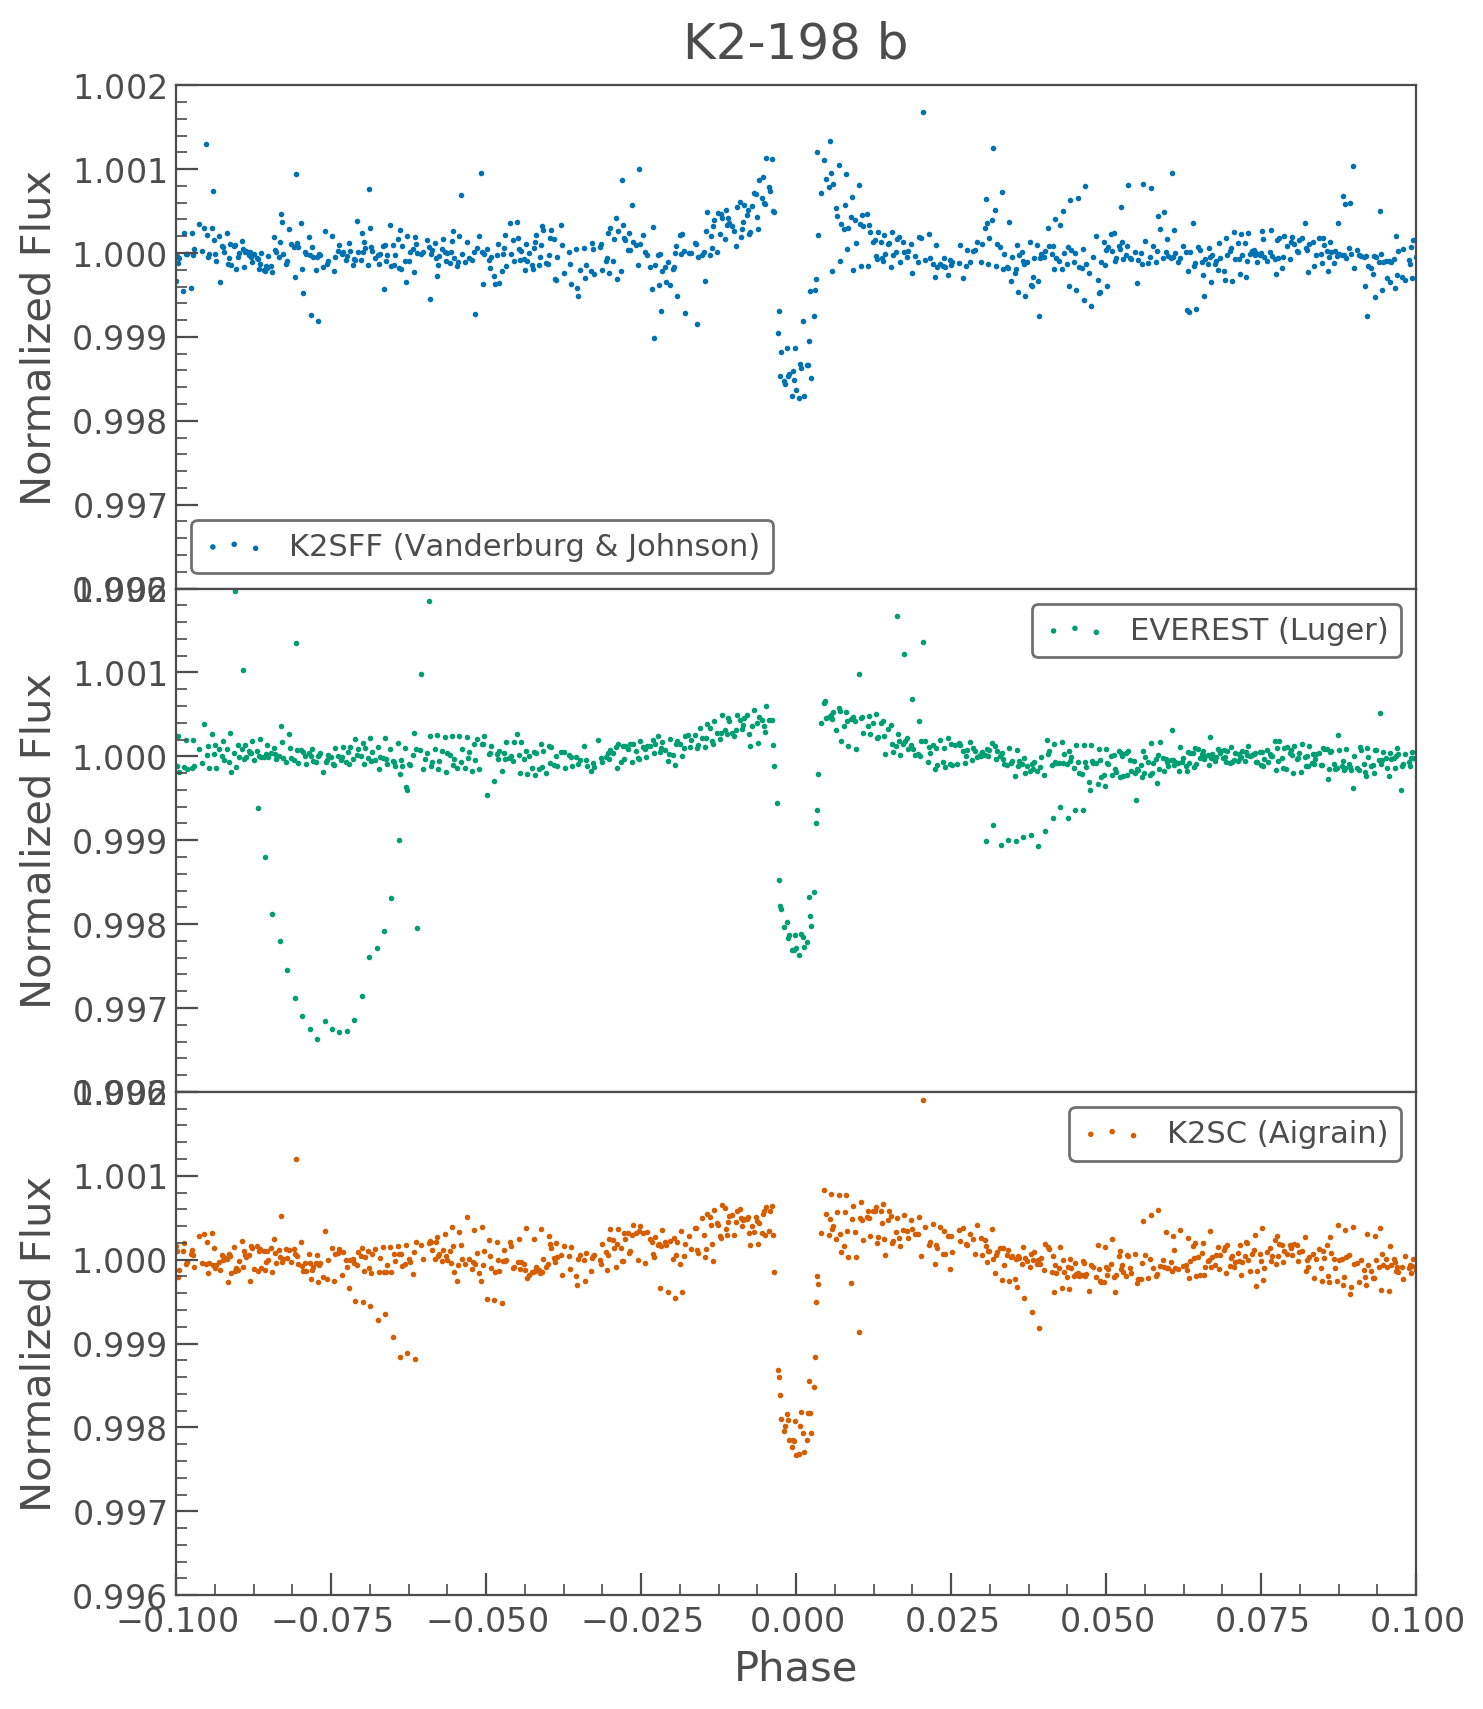

In [9]:
fig, ax = plt.subplots(3, figsize=(8, 10))
for idx, lc1 in enumerate(hlsps):
    # Mask planet 2
    lc1.flux_err[~np.isfinite(lc1.flux_err)] = 0.0005
    lc1 = lc1.remove_nans().normalize()
    lc1 = lc1[lc1.flux > 0.8]
    ph = (lc1.time - t0_1)/period_1 % 1
    out_of_transit_1 = (ph > ((duration_1 * 1.5)/period_1)/2) & (ph < 1 - ((duration_1 * 1.5)/period_1)/2)
    ph = (lc1.time - t0_2)/period_2 % 1
    out_of_transit_2 = (ph > ((duration_2 * 1.5)/period_2)/2) & (ph < 1 - ((duration_2 * 1.5)/period_2)/2)
    
    if idx != 2:
        lc1 = lc1.to_corrector('gp').correct(mask=(~out_of_transit_1 & ~out_of_transit_2), timescale=15, iters=3, sigma=3)
    lc1[out_of_transit_2].fold(period_1, t0_1).scatter(ax=ax[idx], c= 'C{}'.format(idx + 1))
    ax[idx].set_xlim(-0.1, 0.1)
    ax[idx].set_ylim(0.996, 1.002)
    if idx < 2:
        ax[idx].set_xticks([])
    if idx == 0:
        ax[idx].set_title('K2-198 b')
plt.subplots_adjust(hspace=0)

### Using `lightkurve` to detrend long term trends and motion at the same time.

You can use `lightkurve` to iteratively apply a GP and the SFF correction for short term motion. 

In [75]:
# Use the Kepler pipeline product
lc = lcfs[0].PDCSAP_FLUX

# Create a first pass motion correction
rough_lc = lc.to_corrector('sff').correct(restore_trend=True)

# Generate a transit mask
ph = (rough_lc.time - t0_1)/period_1 % 1
out_of_transit = (ph > ((duration_1 * 1.5)/period_1)/2) & (ph < 1 - ((duration_1 * 1.5)/period_1)/2)
ph = (rough_lc.time - t0_2)/period_2 % 1
out_of_transit &= (ph > ((duration_2 * 1.5)/period_2)/2) & (ph < 1 - ((duration_2 * 1.5)/period_2)/2)

# Correct the long term trends
corrected_lc, trend = rough_lc.to_corrector('gp').correct(mask=~out_of_transit, return_trend=True, timescale=15, iters=3, sigma=3)

# Run a better motion detrending
motion_corrected_lc = corrected_lc.to_corrector('sff').correct()

The above method produces a much better fit to the long term variability:

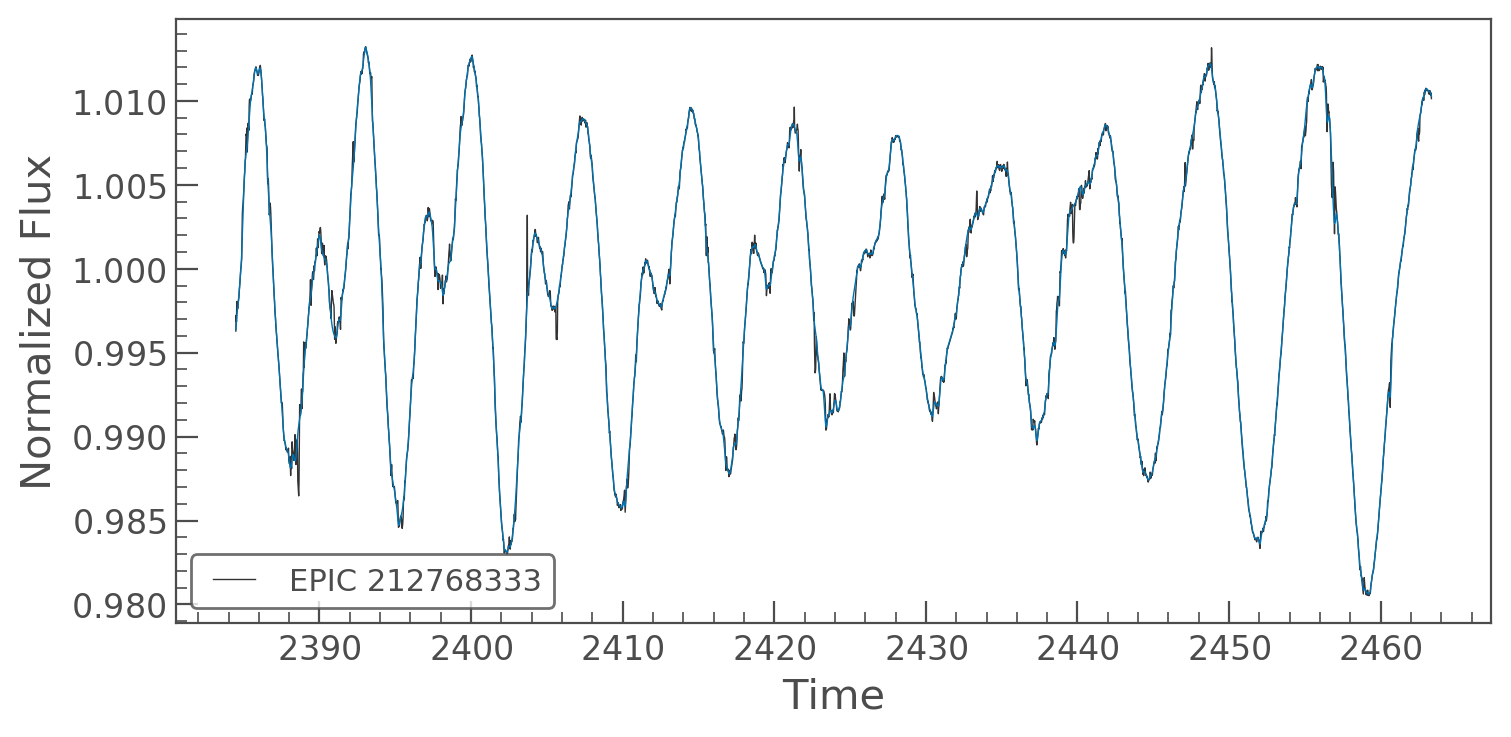

In [71]:
ax = rough_lc.plot()
trend.plot(ax=ax)

...and when this trend is removed, the transits from both planets become clear. 

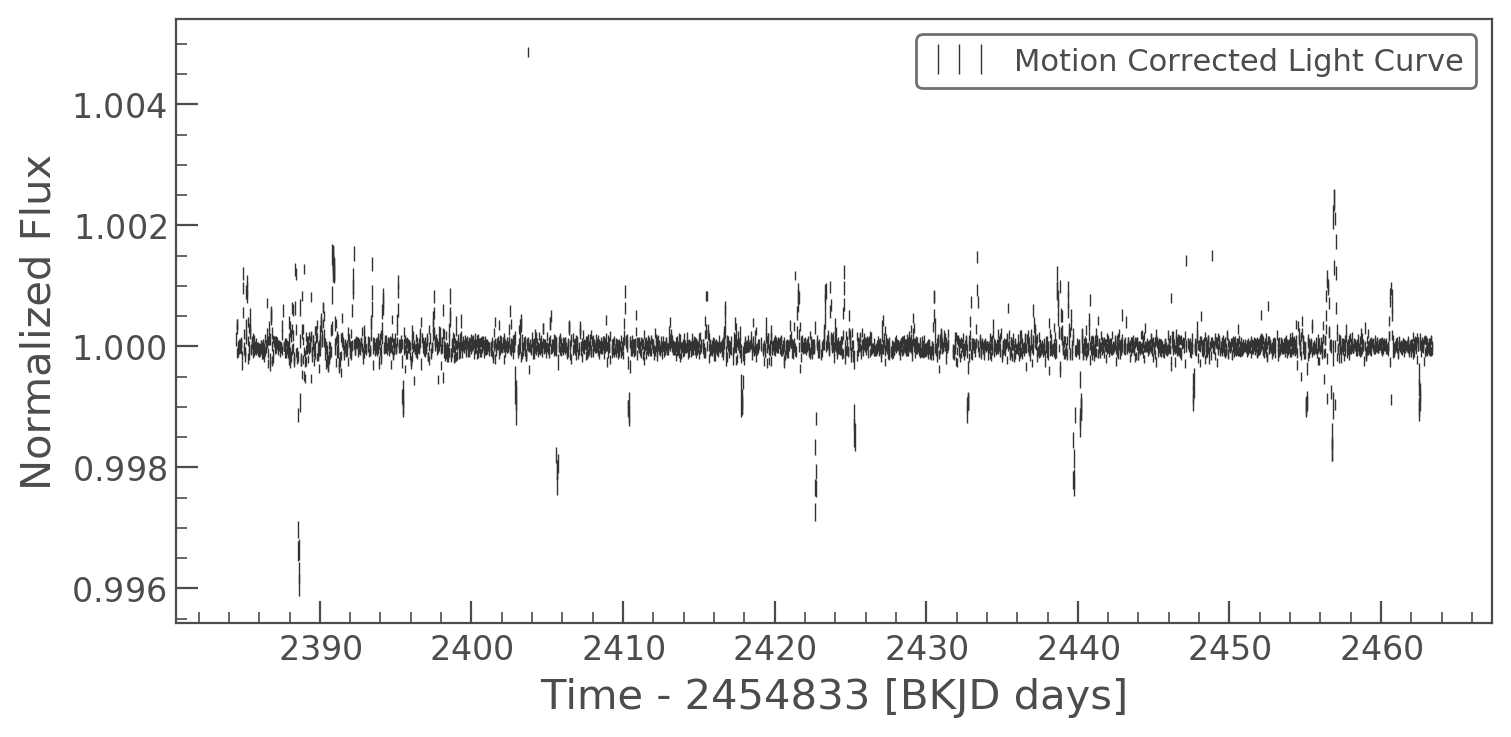

In [74]:
motion_corrected_lc.errorbar(label='Motion Corrected Light Curve')

It would be possible to iteratively improve this fit until the best light curve possible is reached.  Now that we have a reasonable light curve, we can fold them and see the transits. The detrending I've done above is not optimal, and so there are still a few artefacts left, but the transits are very clear. A future project will use the `exoplanet` package for our long term detrending!

(0.998, 1.002)

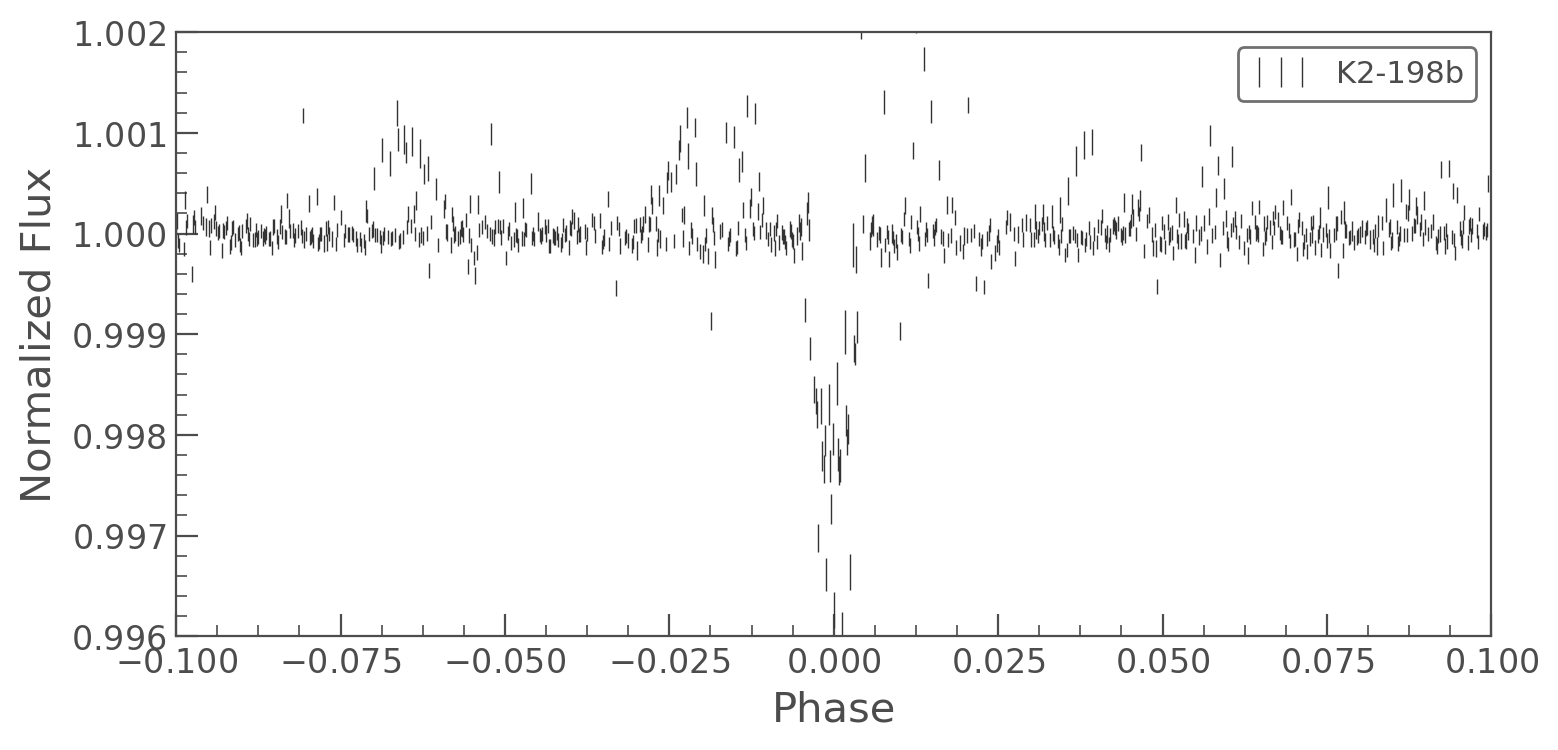

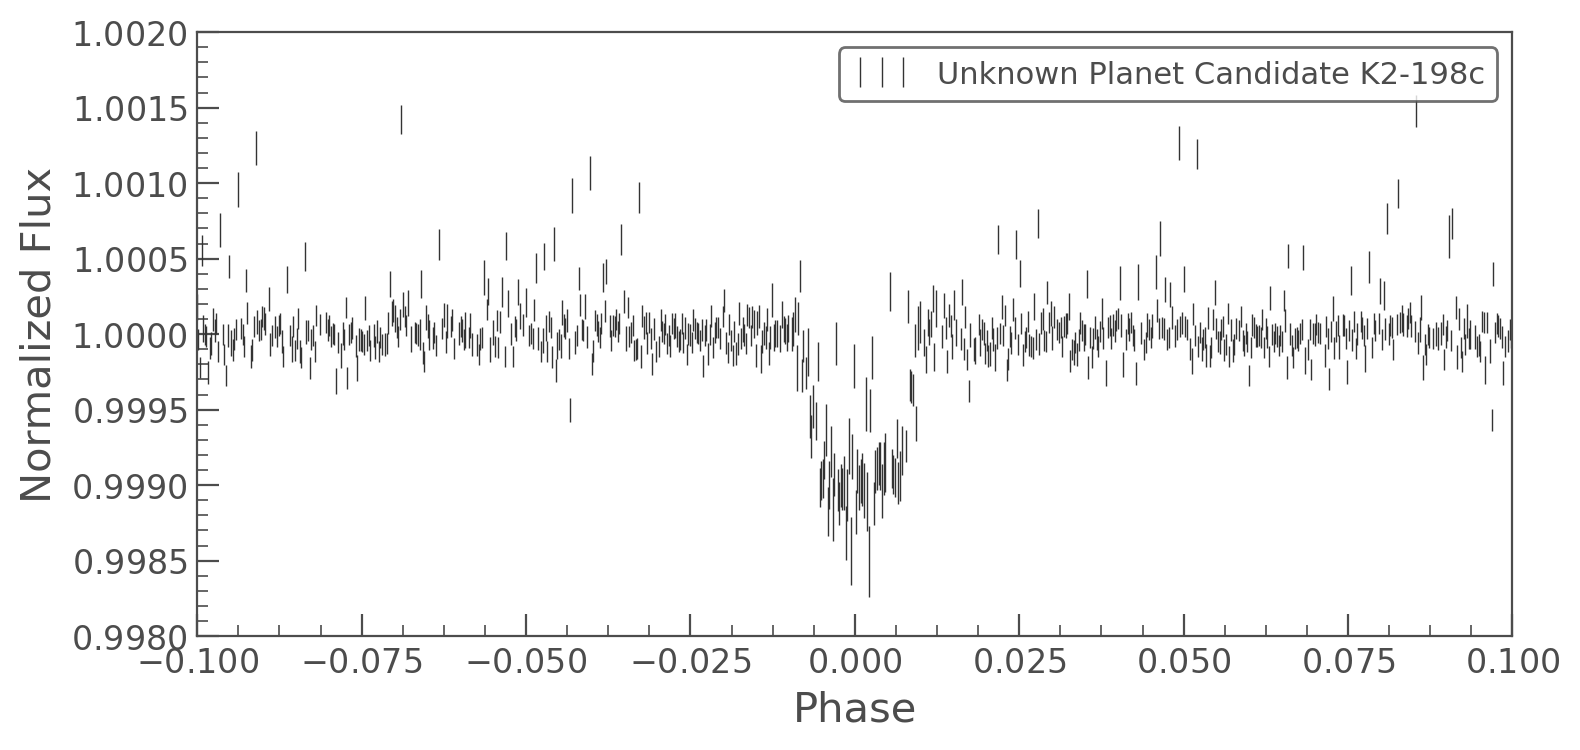

In [81]:
ph = (motion_corrected_lc.time - t0_2)/period_2 % 1
mask = (ph > ((duration_2 * 1.5)/period_2)/2) & (ph < 1 - ((duration_2 * 1.5)/period_2)/2)

ax = motion_corrected_lc[mask].fold(period_1, t0_1).errorbar(label='K2-198b')
ax.set_xlim(-0.1, 0.1)
ax.set_ylim(0.996, 1.002)

ph = (motion_corrected_lc.time - t0_1)/period_1 % 1
mask = (ph > ((duration_1 * 1.5)/period_1)/2) & (ph < 1 - ((duration_1 * 1.5)/period_1)/2)

ax = motion_corrected_lc[mask].fold(period_2, t0_2).errorbar(label='Unknown Planet Candidate K2-198c')
ax.set_xlim(-0.1, 0.1)
ax.set_ylim(0.998, 1.002)